# YOLOv8 Model on KITTI Dataset

Due to high file size of input images, the system can result in out of memory error. hence it is better to compress the images before training.

**Note: The original images are compressed and available in the GitHub. If you want orginal dataset, visit [KITTI Dataset for Object Detection](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d)**

If you have the original `.png` images from the official website, uncomment and use the below code for compressing it.

In [3]:
# Compress training images

# from PIL import Image
# import os

# input_folder = 'data_object_image_2/training/image_2'
# output_folder = 'data_object_image_2/training/compressed_images'

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# for filename in os.listdir(input_folder):
#     if filename.endswith(".png"):
#         img_path = os.path.join(input_folder, filename)
#         img = Image.open(img_path)
        
#         # Compress image by reducing the quality
#         output_path = os.path.join(output_folder, filename.replace('.png', '.jpg'))
#         img.save(output_path, "JPEG", quality=85)  # Adjust the quality as needed

### Split the dataset into Train and Validation

After clearing the directories (if they have any files), we create `image` and `label` directories for both `train` and `val`. Randomly split the images in 80-20 ratio for training and validation and get corresponding annotation files in respective directories.

In [28]:
import os
import shutil
import random

def clear_directory(directory):
    """Remove all files and subdirectories in the given directory."""
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            

# Paths training instances of images and labels
image_dir = "data_object_image_2/training/compressed_images/"
label_dir = "data_object_label_2/training/label_2/"

# Output directories for split dataset
train_images = "datasets/train/images"
val_images = "datasets/val/images"
train_labels = "datasets/train/labels"
val_labels = "datasets/val/labels"

# Clear existing files in target directories
def clear_and_prepare_dir(directories):
    """Clear and prepare the specified directories."""
    for directory in directories:
        if os.listdir(directory):
            print(f"Clearing existing files in {directory}...")
            clear_directory(directory)
            print(f"Directory {directory} has been cleared!")
        os.makedirs(directory, exist_ok=True)

clear_and_prepare_dir([train_images, val_images, train_labels, val_labels])

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Split the dataset (80% train, 20% validation)
split_ratio = 0.8
train_size = int(split_ratio * len(image_files))
train_files = image_files[:train_size]
val_files = image_files[train_size:]

# Copy files to respective directories
for file_name in train_files:
    base_name = os.path.splitext(file_name)[0]
    shutil.copy(os.path.join(image_dir, file_name), os.path.join(train_images, file_name))
    shutil.copy(os.path.join(label_dir, base_name + ".txt"), os.path.join(train_labels, base_name + ".txt"))

for file_name in val_files:
    base_name = os.path.splitext(file_name)[0]
    shutil.copy(os.path.join(image_dir, file_name), os.path.join(val_images, file_name))
    shutil.copy(os.path.join(label_dir, base_name + ".txt"), os.path.join(val_labels, base_name + ".txt"))

print("Dataset has been split and copied!")

Clearing existing files in datasets/train/images...
Directory datasets/train/images has been cleared!
Dataset has been split and copied!


### Visualize Images and Bounding Box with Classes

Visualize some of the training images, with their bounding boxes and corresponding label class to verify the data.

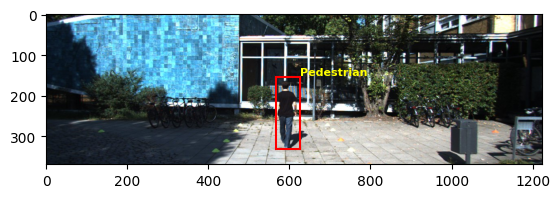

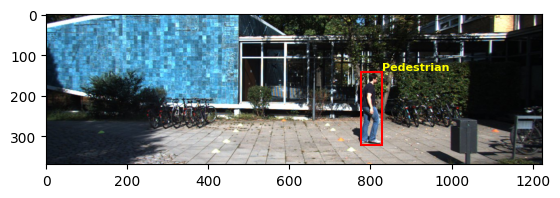

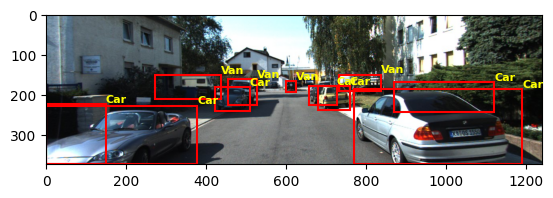

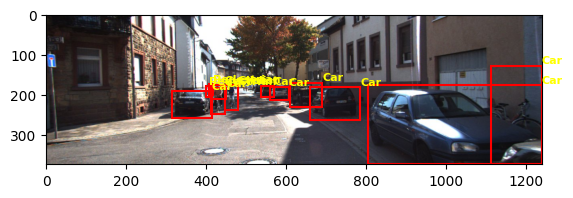

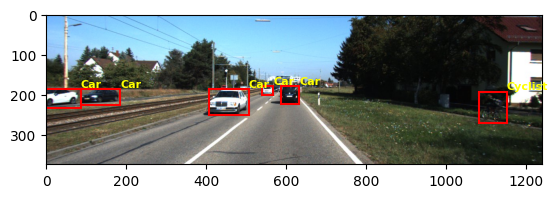

In [32]:
%matplotlib inline
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define KITTI classes
category = {"Car": 1, "Pedestrian": 2, "Cyclist": 3, "Van": 4,
            "Truck": 5, "Person_sitting": 6, "Tram": 7, "Misc": 8}

# Inverse mapping for visualization
category_inverse = {v: k for k, v in category.items()}

def plot_image_with_bbox(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    with open(label_path, 'r') as file:
        lines = file.readlines()

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for line in lines:
        data = line.strip().split(' ')
        class_name = data[0]

        # Skip if class name is dontcare
        if class_name.lower() == "dontcare":
            continue
            
        x_min = float(data[4])
        y_min = float(data[5])
        x_max = float(data[6])
        y_max = float(data[7])

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label text
        plt.text(x_max, y_min, class_name, color='yellow', fontsize=8,
                verticalalignment='bottom', horizontalalignment='left',
                fontweight='bold')

    plt.show()
    plt.close(fig)

# Directory paths
image_dir = "datasets/train/images"
label_dir = "datasets/train/labels"

# Display random images with bounding boxes
for _ in range(5):  # 5 random images
    img_name = random.choice(os.listdir(image_dir))
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))
    plot_image_with_bbox(img_path, label_path)


### Convert Annotations into YOLO lables

Convert the annotation files to labels which are supported by YOLO. Yolo label is of the format <br>
`<class_id> <x_center> <y_center> <width> <height>` <br>
Where:

- `<class_id>`: The integer index of the class (e.g., 0 for "Car", 1 for "Pedestrian").
- `<x_center>`: The x-coordinate of the center of the bounding box, normalized by the image width (a value between 0 and 1).
- `<y_center>`: The y-coordinate of the center of the bounding box, normalized by the image height (a value between 0 and 1).
- `<width>`: The width of the bounding box, normalized by the image width (a value between 0 and 1).
- `<height>`: The height of the bounding box, normalized by the image height (a value between 0 and 1).

In [3]:
import os
import cv2

# Class mapping
category = {
    "Car": 1, "Pedestrian": 2, "Cyclist": 3, "Van": 4,
    "Truck": 5, "Person_sitting": 6, "Tram": 7, "Misc": 8
}

# Paths for the dataset that are being split
train_images = "datasets/train/images"
val_images = "datasets/val/images"
train_labels = "datasets/train/labels"
val_labels = "datasets/val/labels"

# Directories
train_labels_dir = "datasets/train/labels"
val_labels_dir = "datasets/val/labels"

# Function to convert coco annotations to yolo labels
def convert_coco_to_yolo(coco_file, img_width, img_height):
    yolo_data = []
    with open(coco_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split(' ')
            class_name = data[0]

            # Skip if the class is "DontCare"
            if class_name.lower() == "dontcare":
                continue

            # Get class_id (YOLO uses 0-indexed class ids)
            class_id = category[class_name] - 1

            # Extract bounding box coordinates
            x_min = float(data[4])
            y_min = float(data[5])
            x_max = float(data[6])
            y_max = float(data[7])

            # Convert to YOLO format
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            # Append to yolo_data list
            yolo_data.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    return yolo_data

# Convert all label files in the directory to YOLO format
def process_directory(label_dir, img_dir):
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            img_file = label_file.replace('.txt', '.jpg')  # Assuming .jpg images
            img_path = os.path.join(img_dir, img_file)

            # Load the image to get dimensions
            img = cv2.imread(img_path)
            img_h, img_w = img.shape[:2]

            # Convert the COCO label to YOLO format
            yolo_data = convert_coco_to_yolo(label_path, img_w, img_h)

            # Write the YOLO-formatted labels to the same file (overwrite)
            with open(label_path, 'w') as f:
                f.writelines(yolo_data)

# Convert train and validation labels
process_directory(train_labels_dir, train_images)
process_directory(val_labels_dir, val_images)

print("Labels have been converted to YOLO format!")


Labels have been converted to YOLO format!


### The `.yml` file for training YOLOv8 model

Create a YAML file for the YOLOv8 model, which includes the train and validation directories, number of classes and corresponding class labels.

### Train the YOLOv8 Model

Train the YOLOv8 model using a pretrained nano version of `yolov8n.pt` using our KITTI dataset.

In [1]:
import time
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")  # Using the nano version for quick training

# Measure training time for YOLOv8
start_time = time.time()

# Train the model
model.train(data='data.yml', epochs=4, batch=8, imgsz=640)

end_time = time.time()

Ultralytics YOLOv8.2.78  Python-3.11.4 torch-2.2.2 CPU (Intel Core(TM) i3-7100U 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yml, epochs=4, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning E:\Bhagavath\Final Project\datasets\train\labels.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|█
val: Scanning E:\Bhagavath\Final Project\datasets\val\labels.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|█████


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4         0G      1.388      1.698      1.106         93        640: 100%|██████████| 748/748 [1:26:36<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [03:45


                   all       1497       8090      0.568       0.32      0.358      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4         0G      1.256      1.169      1.068        123        640: 100%|██████████| 748/748 [1:24:10<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [03:06


                   all       1497       8090       0.55      0.413      0.434      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4         0G      1.194      1.018      1.043         86        640: 100%|██████████| 748/748 [1:23:11<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [03:04


                   all       1497       8090       0.57      0.506      0.516      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4         0G       1.13     0.9032       1.02         91        640: 100%|██████████| 748/748 [1:24:01<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [03:03


                   all       1497       8090      0.681      0.513      0.586       0.38

4 epochs completed in 5.855 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.78  Python-3.11.4 torch-2.2.2 CPU (Intel Core(TM) i3-7100U 2.40GHz)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [02:33


                   all       1497       8090      0.681      0.513      0.586       0.38
                   Car       1314       5738      0.788      0.853      0.889      0.639
            Pedestrian        386        966      0.679      0.547      0.612      0.325
               Cyclist        224        326       0.69      0.319      0.456      0.234
                   Van        413        546      0.724      0.553      0.651      0.444
                 Truck        185        194      0.752       0.68      0.739      0.565
        Person_sitting         19         45      0.544      0.156      0.254      0.131
                  Tram         74        100      0.563      0.787      0.764      0.496
                  Misc        134        175      0.706      0.206       0.32      0.201
Speed: 0.8ms preprocess, 82.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train


Training time taken by YOLOv8

In [2]:
yolov8_training_time = end_time - start_time
print(f"YOLOv8 training time: {yolov8_training_time:.2f} seconds")

YOLOv8 training time: 21266.59 seconds


The YOLOv8 model took almost 5.90 hours to train the custom KITTI dataset 5984 instances.

### Validation

Validation of the trained model with validation dataset on 1497 instances.

In [3]:
start_time = time.time()

# validation
metrics = model.val()

end_time = time.time()
yolov8_validation_time = end_time - start_time
print(f"YOLOv8 validation time: {yolov8_validation_time:.2f} seconds")

Ultralytics YOLOv8.2.78  Python-3.11.4 torch-2.2.2 CPU (Intel Core(TM) i3-7100U 2.40GHz)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning E:\Bhagavath\Final Project\datasets\val\labels.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|█████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [03:


                   all       1497       8090      0.681      0.513      0.586       0.38
                   Car       1314       5738      0.788      0.853      0.889      0.639
            Pedestrian        386        966      0.679      0.547      0.612      0.325
               Cyclist        224        326       0.69      0.319      0.456      0.234
                   Van        413        546      0.724      0.553      0.651      0.444
                 Truck        185        194      0.752       0.68      0.739      0.565
        Person_sitting         19         45      0.544      0.156      0.254      0.131
                  Tram         74        100      0.563      0.787      0.764      0.496
                  Misc        134        175      0.706      0.206       0.32      0.201
Speed: 0.9ms preprocess, 97.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train2
YOLOv8 validation time: 190.83 seconds


The model took a validation time of 190.85 seconds (3.16 mins).

### Evaluation Metrices

We extract the evaluation metrices of precision, recall and mean accuracy precision.

The evaluation metrices are stored in `results.csv` file in `run/detect/train` directory for each epoch. We can extract the values from there.

In [13]:
import pandas as pd

# Load the CSV file
results_path = "runs/detect/train/results.csv"
df = pd.read_csv(results_path)

# Extract precision, recall, mAP_50, and mAP_50-95
precision = df['metrics/precision(B)'][3]
recall = df['metrics/recall(B)'][3]
map_50 = df['metrics/mAP50(B)'][3]
map_50_95 = df['metrics/mAP50-95(B)'][3]

# Print the metrics for the 4th epoch
print(f"Epoch 4 :")
print(f"    Precision: {precision:.4f}")
print(f"    Recall: {recall:.4f}")
print(f"    mAP_50: {map_50:.4f}")
print(f"    mAP_50-95: {map_50_95:.4f}")


Epoch 4 :
    Precision: 0.6809
    Recall: 0.5130
    mAP_50: 0.5858
    mAP_50-95: 0.3796


#### Confusion Matrix

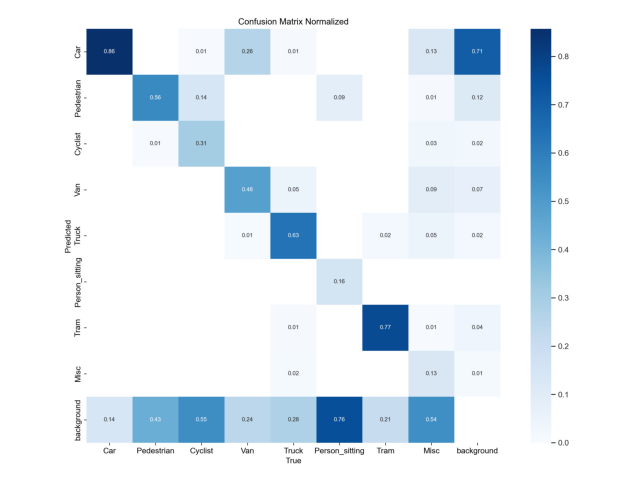

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the directory and the image filename
image_directory = 'runs/detect/train2/'
image_filename = 'confusion_matrix_normalized.png'  # Replace with your image file name

# Construct the full image path
image_path = os.path.join(image_directory, image_filename)

# Load the image
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Prediction and Visualization

Use the trained YOLOv8 model to test some of the image instances and check its consistency.

In [5]:
from ultralytics import YOLO

# Predicting the Image Outputs
model = YOLO("runs/detect/train/weights/best.pt") # load model
results = model("datasets/test", save=True)


image 1/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000000.png: 224x640 1 Car, 155.6ms
image 2/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000001.png: 224x640 3 Cars, 199.3ms
image 3/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000002.png: 224x640 8 Cars, 115.9ms
image 4/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000003.png: 224x640 4 Cars, 154.8ms
image 5/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\datasets\test\000004.png: 224x640 1 Car, 1 Truck, 79.8ms
image 6/11 D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti D

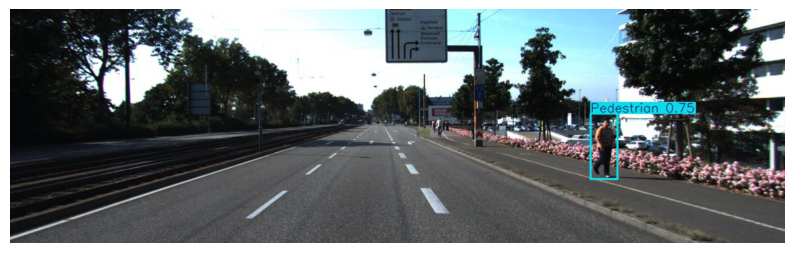

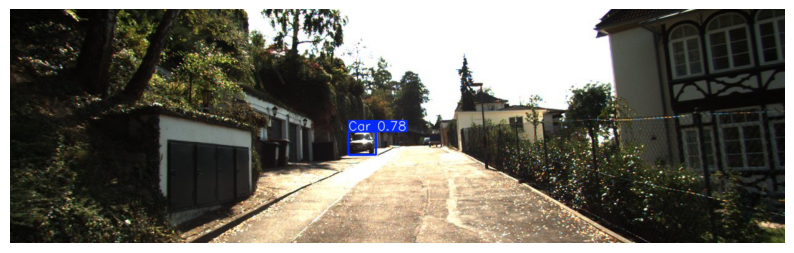

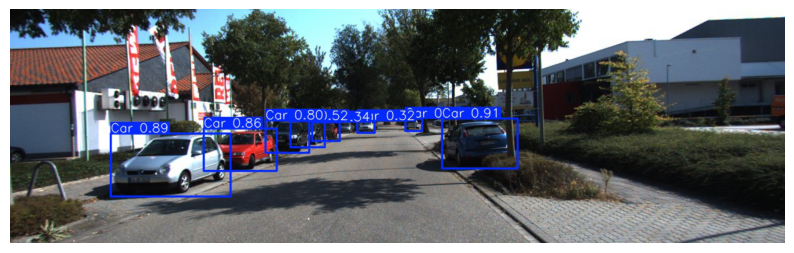

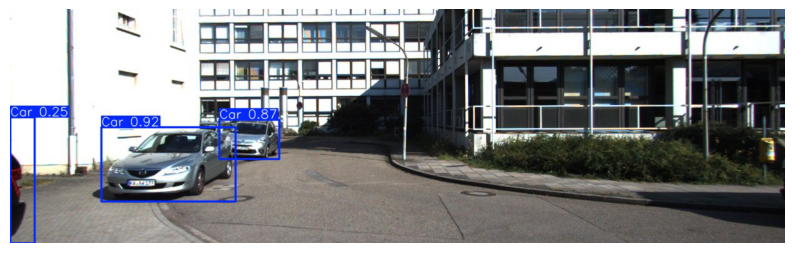

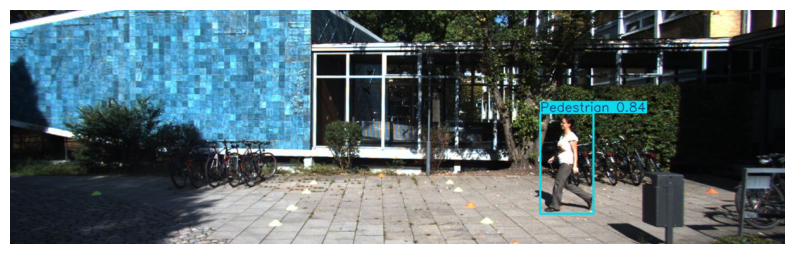

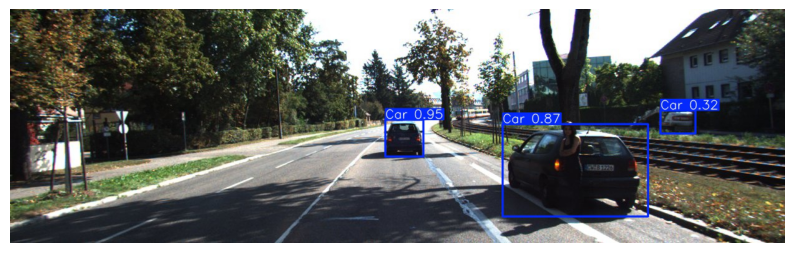

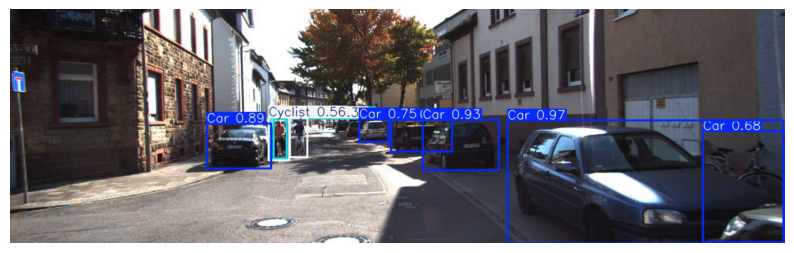

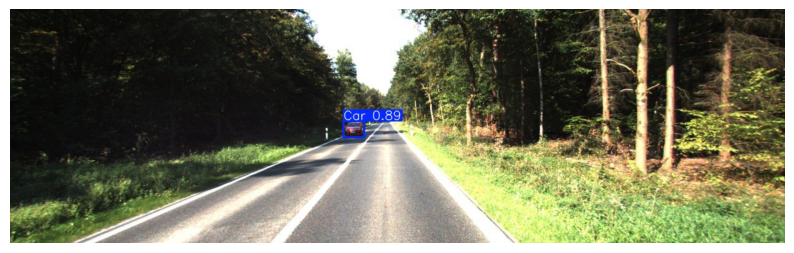

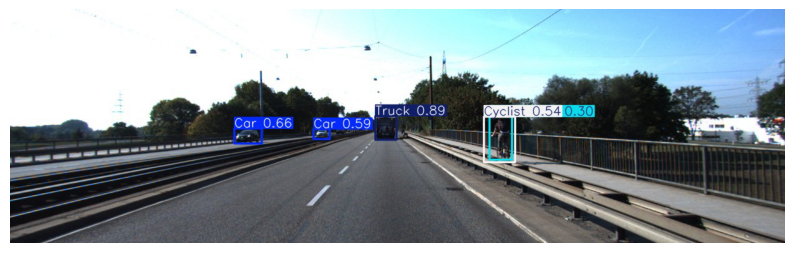

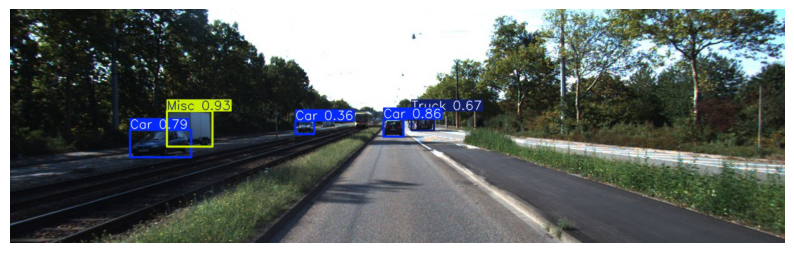

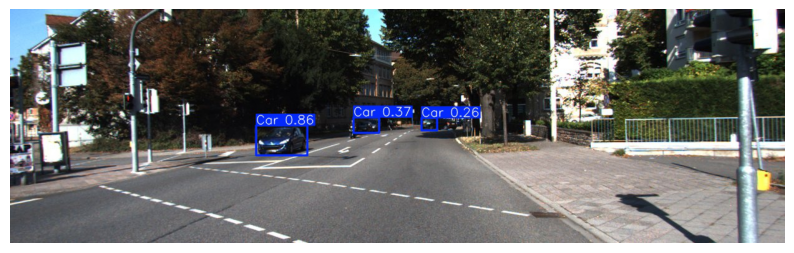

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory where YOLO saves the results
results_dir = "runs/detect/predict"

# List and display images with bounding boxes and labels
for img_file in os.listdir(results_dir):
    if img_file.endswith((".png", ".jpg")):
        img_path = os.path.join(results_dir, img_file)
        
        # Open and display the image
        img = Image.open(img_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()


Almost all the objects were predicted correctly with good level of accuracy. But only thing ot note is that it is difficult to detect small or far objects in the image.

### Predicting Video input

We use the same trained model to predict a video file and check if it correctly predicts the onjects.

In [40]:
# Predicting video inputs

import time

start_time = time.time()
file_name = "road-video-dubai.mp4"
result = model(file_name, save=True)
end_time = time.time()

# stream-True is not given inorder to calculate the video processing time. If we give this option as true,
# the file will be processed in the background nad will be ready after completion.



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/906) D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\road-video-dubai.mp4: 384x640 7 Cars, 198.2ms
video 1/1 (frame 2/906) D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimester\Math Modelling Project\Dataset\Kitti Dataset\road-video-dubai.mp4: 384x640 9 Cars, 152.2ms
video 1/1 (frame 3/906) D:\Bhagavath\UCD\Data and Computaional Science\03 - Summer Trimest

video 1/1 (frame 380/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 413.9ms
video 1/1 (frame 381/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 759.0ms
video 1/1 (frame 382/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 722.1ms
video 1/1 (frame 383/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 363.5ms
video 1/1 (frame 384/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 330.1ms
video 1/1 (frame 385/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 254.3ms
video 1/1 (frame 386/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 253.1ms
video 1/1 (frame 387/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 257.3ms
video 1/1 (frame 388/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 262.3ms
video 1/1 (frame 389/1798) E

video 1/1 (frame 456/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 238.4ms
video 1/1 (frame 457/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 2 Vans, 1 Truck, 247.3ms
video 1/1 (frame 458/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 2 Vans, 1 Truck, 232.4ms
video 1/1 (frame 459/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 2 Vans, 1 Truck, 254.3ms
video 1/1 (frame 460/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 233.4ms
video 1/1 (frame 461/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 1 Truck, 228.4ms
video 1/1 (frame 462/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 226.4ms
video 1/1 (frame 463/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 226.4ms
video 1/1 (frame 464/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 1 Truck, 232.0ms
video 1/1 (frame 465/1798

video 1/1 (frame 532/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 1 Truck, 206.4ms
video 1/1 (frame 533/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 224.4ms
video 1/1 (frame 534/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 231.8ms
video 1/1 (frame 535/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 1 Truck, 223.4ms
video 1/1 (frame 536/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 1 Truck, 195.5ms
video 1/1 (frame 537/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 4 Cars, 2 Vans, 1 Truck, 205.5ms
video 1/1 (frame 538/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 221.4ms
video 1/1 (frame 539/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 213.4ms
video 1/1 (frame 540/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 1 Truck, 281.2ms
video 1/1 (frame 541/1798) E:\Bh

video 1/1 (frame 615/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 3 Vans, 1 Truck, 235.4ms
video 1/1 (frame 616/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 2 Trucks, 233.4ms
video 1/1 (frame 617/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 2 Vans, 1 Truck, 228.4ms
video 1/1 (frame 618/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 227.4ms
video 1/1 (frame 619/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Truck, 235.4ms
video 1/1 (frame 620/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Truck, 227.4ms
video 1/1 (frame 621/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 1 Truck, 225.4ms
video 1/1 (frame 622/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Truck, 233.4ms
video 1/1 (frame 623/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Truck, 224.4ms
video 1/1 (frame 624/1798) E:\Bhagavath\Final Projec

video 1/1 (frame 701/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 225.4ms
video 1/1 (frame 702/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 235.4ms
video 1/1 (frame 703/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 229.4ms
video 1/1 (frame 704/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 267.3ms
video 1/1 (frame 705/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 262.3ms
video 1/1 (frame 706/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 245.3ms
video 1/1 (frame 707/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 224.4ms
video 1/1 (frame 708/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 219.4ms
video 1/1 (frame 709/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 222.4ms
video 1/1 (frame 710/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 227.4ms
video 1/1 (frame 711/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Ca

video 1/1 (frame 789/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 229.4ms
video 1/1 (frame 790/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 240.4ms
video 1/1 (frame 791/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 233.4ms
video 1/1 (frame 792/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 231.4ms
video 1/1 (frame 793/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 235.4ms
video 1/1 (frame 794/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 240.4ms
video 1/1 (frame 795/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 229.4ms
video 1/1 (frame 796/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 228.4ms
video 1/1 (frame 797/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 235.4ms
video 1/1 (frame 798/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 230.4ms
video 1/1 (frame 799/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Ca

video 1/1 (frame 874/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 233.0ms
video 1/1 (frame 875/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Truck, 231.4ms
video 1/1 (frame 876/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 230.4ms
video 1/1 (frame 877/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 226.4ms
video 1/1 (frame 878/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 238.4ms
video 1/1 (frame 879/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 247.3ms
video 1/1 (frame 880/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 245.3ms
video 1/1 (frame 881/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 10 Cars, 236.8ms
video 1/1 (frame 882/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 10 Cars, 267.8ms
video 1/1 (frame 883/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 10 Cars, 1 Truck, 234.4ms
video 1/1 (frame 884/1798) E:\Bhagavath\Final Project\dashc

video 1/1 (frame 963/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 238.4ms
video 1/1 (frame 964/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 234.4ms
video 1/1 (frame 965/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 241.4ms
video 1/1 (frame 966/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 230.8ms
video 1/1 (frame 967/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 259.1ms
video 1/1 (frame 968/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 260.3ms
video 1/1 (frame 969/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 254.3ms
video 1/1 (frame 970/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 246.2ms
video 1/1 (frame 971/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 232.4ms
video 1/1 (frame 972/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 233.9ms
video 1/1 (frame 973/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Ca

video 1/1 (frame 1052/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 214.2ms
video 1/1 (frame 1053/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 210.4ms
video 1/1 (frame 1054/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 237.4ms
video 1/1 (frame 1055/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 232.1ms
video 1/1 (frame 1056/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 223.4ms
video 1/1 (frame 1057/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 230.2ms
video 1/1 (frame 1058/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 230.4ms
video 1/1 (frame 1059/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 224.0ms
video 1/1 (frame 1060/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 227.7ms
video 1/1 (frame 1061/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 226.4ms
video 1/1 (frame 1062/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 3

video 1/1 (frame 1139/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 228.4ms
video 1/1 (frame 1140/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 223.4ms
video 1/1 (frame 1141/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 229.4ms
video 1/1 (frame 1142/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 232.4ms
video 1/1 (frame 1143/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 230.4ms
video 1/1 (frame 1144/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 231.4ms
video 1/1 (frame 1145/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 224.4ms
video 1/1 (frame 1146/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 236.9ms
video 1/1 (frame 1147/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 236.4ms
video 1/1 (frame 1148/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 224.0ms
video 1/1 (fra

video 1/1 (frame 1225/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 238.4ms
video 1/1 (frame 1226/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 231.5ms
video 1/1 (frame 1227/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 242.4ms
video 1/1 (frame 1228/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 234.4ms
video 1/1 (frame 1229/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 235.4ms
video 1/1 (frame 1230/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 10 Cars, 1 Van, 215.4ms
video 1/1 (frame 1231/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 243.3ms
video 1/1 (frame 1232/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 230.4ms
video 1/1 (frame 1233/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 407.9ms
video 1/1 (frame 1234/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 235.4ms

video 1/1 (frame 1307/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 228.4ms
video 1/1 (frame 1308/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 233.4ms
video 1/1 (frame 1309/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 236.4ms
video 1/1 (frame 1310/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 238.4ms
video 1/1 (frame 1311/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 228.4ms
video 1/1 (frame 1312/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 314.2ms
video 1/1 (frame 1313/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 286.2ms
video 1/1 (frame 1314/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 234.4ms
video 1/1 (frame 1315/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 228.4ms
video 1/1 (frame 1316/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 364.3ms


video 1/1 (frame 1389/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 241.4ms
video 1/1 (frame 1390/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 220.4ms
video 1/1 (frame 1391/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 294.5ms
video 1/1 (frame 1392/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 230.4ms
video 1/1 (frame 1393/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 252.1ms
video 1/1 (frame 1394/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 278.6ms
video 1/1 (frame 1395/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 208.4ms
video 1/1 (frame 1396/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 213.4ms
video 1/1 (frame 1397/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 9 Cars, 1 Van, 229.4ms
video 1/1 (frame 1398/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 214.4ms


video 1/1 (frame 1471/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 241.4ms
video 1/1 (frame 1472/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 242.4ms
video 1/1 (frame 1473/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 236.4ms
video 1/1 (frame 1474/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 239.4ms
video 1/1 (frame 1475/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 234.4ms
video 1/1 (frame 1476/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 226.4ms
video 1/1 (frame 1477/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 241.4ms
video 1/1 (frame 1478/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 356.0ms
video 1/1 (frame 1479/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 247.3ms
video 1/1 (frame 1480/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 236.4ms


video 1/1 (frame 1553/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 237.2ms
video 1/1 (frame 1554/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 244.3ms
video 1/1 (frame 1555/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 234.4ms
video 1/1 (frame 1556/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 236.4ms
video 1/1 (frame 1557/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 233.4ms
video 1/1 (frame 1558/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 232.4ms
video 1/1 (frame 1559/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 233.4ms
video 1/1 (frame 1560/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 245.3ms
video 1/1 (frame 1561/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 2 Vans, 234.4ms
video 1/1 (frame 1562/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 239.4ms

video 1/1 (frame 1635/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 237.4ms
video 1/1 (frame 1636/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 239.4ms
video 1/1 (frame 1637/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 237.4ms
video 1/1 (frame 1638/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 249.3ms
video 1/1 (frame 1639/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 7 Cars, 1 Van, 236.4ms
video 1/1 (frame 1640/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 8 Cars, 1 Van, 244.4ms
video 1/1 (frame 1641/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 231.4ms
video 1/1 (frame 1642/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 232.4ms
video 1/1 (frame 1643/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 237.4ms
video 1/1 (frame 1644/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 291.2ms


video 1/1 (frame 1717/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 218.4ms
video 1/1 (frame 1718/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 227.4ms
video 1/1 (frame 1719/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 210.4ms
video 1/1 (frame 1720/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 227.4ms
video 1/1 (frame 1721/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 226.4ms
video 1/1 (frame 1722/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 6 Cars, 1 Van, 227.4ms
video 1/1 (frame 1723/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 236.4ms
video 1/1 (frame 1724/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 223.4ms
video 1/1 (frame 1725/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 227.4ms
video 1/1 (frame 1726/1798) E:\Bhagavath\Final Project\dashcam2.mp4: 384x640 5 Cars, 1 Van, 225.4ms


Speed: 7.7ms preprocess, 244.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


In [38]:
inference_time = end_time - start_time
print(f"Inference Time for video file {file_name} : {inference_time:.2f} seconds")

Inference Time for video file 002050.jpg : 278.50 seconds


The trained yolov8 model takes 149 seconds to process the video, which is considerable (not best or suitable) for real time application compared to Faster R-CNN model.

A comparison between Faster R-CNN and YOLOv8 models are made in the file `model_comparison.ipynb`.